In [112]:
# import dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn import metrics

In [113]:
# read in csv as dataframe
county_df = pd.read_csv("county_data_mlseg2.csv", index_col=0)
county_df.head()

,county,state,lat,long,TotalPop,total_votes20,votes20_Donald_Trump,votes20_Joe_Biden,percentage20_Donald_Trump,percentage20_Joe_Biden,...,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
0,Abbeville,SC,34.223334,-82.461707,24788.0,12433.0,8215.0,4101.0,0.661,0.330,...,1.8,1.8,6.5,25.8,9505.0,78.8,13.3,7.8,0.1,9.4
1,Acadia,LA,30.295065,-92.414197,62607.0,28425.0,22596.0,5443.0,0.795,0.191,...,1.6,2.2,2.5,27.6,24982.0,80.0,12.1,7.6,0.3,8.9
2,Accomack,VA,37.767072,-75.632346,32840.0,16938.0,9172.0,7578.0,0.542,0.447,...,2.6,1.8,4.5,22.0,13837.0,74.6,18.1,7.1,0.2,5.4
3,Ada,ID,43.452658,-116.241552,435117.0,259389.0,130699.0,120539.0,0.504,0.465,...,1.5,2.8,6.9,20.4,214984.0,78.3,15.0,6.6,0.1,4.3
4,Adair,IA,41.330756,-94.471059,7192.0,4183.0,2917.0,1197.0,0.697,0.286,...,2.8,0.4,6.2,22.3,3680.0,73.8,15.3,10.4,0.5,3.0


In [114]:
# check columns
county_df.columns

Index(['county', 'state', 'lat', 'long', 'TotalPop', 'total_votes20',
       'votes20_Donald_Trump', 'votes20_Joe_Biden',
       'percentage20_Donald_Trump', 'percentage20_Joe_Biden', 'cases',
       'deaths', 'Men', 'Women', 'Hispanic', 'White', 'Black', 'Native',
       'Asian', 'Pacific', 'Income', 'IncomePerCap', 'Poverty', 'Professional',
       'Service', 'Office', 'Construction', 'Production', 'Drive', 'Carpool',
       'Transit', 'Walk', 'OtherTransp', 'WorkAtHome', 'MeanCommute',
       'Employed', 'PrivateWork', 'PublicWork', 'SelfEmployed', 'FamilyWork',
       'Unemployment'],
      dtype='object')

# RFR for Economics

In [115]:
# create economic dataframe for pca
econ_df = county_df[['cases','Income', 'IncomePerCap', 'Poverty', 'Employed', 'Unemployment', 'Professional']]
econ_df.head()

,cases,Income,IncomePerCap,Poverty,Employed,Unemployment,Professional
0,805.0,35254.0,19234.0,22.7,9505.0,9.4,27.2
1,3182.0,40492.0,21591.0,21.5,24982.0,8.9,27.6
2,1227.0,42260.0,24266.0,19.8,13837.0,5.4,31.1
3,17451.0,60151.0,31642.0,11.8,214984.0,4.3,43.0
4,222.0,49477.0,28861.0,9.5,3680.0,3.0,28.2


In [116]:
# create scaled df
econ_scaled = RobustScaler().fit_transform(econ_df)
econ_scaled[:5]

array([[ 0.09694042, -0.88405873, -0.83658255,  0.9375    , -0.04750637,
         1.        , -0.43421053],
       [ 1.62801932, -0.51827022, -0.5065976 ,  0.7875    ,  0.58118634,
         0.85294118, -0.38157895],
       [ 0.36876006, -0.39480438, -0.13209198,  0.575     ,  0.12846422,
        -0.17647059,  0.07894737],
       [10.81900161,  0.85458894,  0.90056351, -0.425     ,  8.29927593,
        -0.5       ,  1.64473684],
       [-0.27858293,  0.10918487,  0.51121767, -0.7125    , -0.28412426,
        -0.88235294, -0.30263158]])

In [117]:
scaled_econ_df = pd.DataFrame(econ_scaled, columns= ['cases','Income', 'IncomePerCap', 'Poverty', 'Employed', 'Unemployment', 'Professional'])
scaled_econ_df.head()

,cases,Income,IncomePerCap,Poverty,Employed,Unemployment,Professional
0,0.096940,-0.884059,-0.836583,0.9375,-0.047506,1.000000,-0.434211
1,1.628019,-0.518270,-0.506598,0.7875,0.581186,0.852941,-0.381579
2,0.368760,-0.394804,-0.132092,0.5750,0.128464,-0.176471,0.078947
3,10.819002,0.854589,0.900564,-0.4250,8.299276,-0.500000,1.644737
4,-0.278583,0.109185,0.511218,-0.7125,-0.284124,-0.882353,-0.302632


In [118]:
y = scaled_econ_df['cases']
scaled_cases = pd.DataFrame(y, columns = ['cases'])
scaled_cases.head()

,cases
0,0.096940
1,1.628019
2,0.368760
3,10.819002
4,-0.278583


In [119]:
X_scaled = scaled_econ_df.drop(['cases'], axis=1)
X_scaled.head()

,Income,IncomePerCap,Poverty,Employed,Unemployment,Professional
0,-0.884059,-0.836583,0.9375,-0.047506,1.000000,-0.434211
1,-0.518270,-0.506598,0.7875,0.581186,0.852941,-0.381579
2,-0.394804,-0.132092,0.5750,0.128464,-0.176471,0.078947
3,0.854589,0.900564,-0.4250,8.299276,-0.500000,1.644737
4,0.109185,0.511218,-0.7125,-0.284124,-0.882353,-0.302632


In [120]:
# initialize pca model
pca = PCA(n_components=2)

In [121]:
# get two principal components for the iris data
X = pca.fit_transform(X_scaled)
X[:5]

array([[-1.66237441,  1.81758077],
       [-1.00409553,  1.36181424],
       [-1.4181055 ,  0.4092722 ],
       [ 6.89369296, -1.41157477],
       [-1.78496402, -0.91629211]])

In [122]:
# instantiate model
regressor = RandomForestRegressor(n_estimators=100,random_state=48)

In [123]:
# split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=48)

In [124]:
# fit model
regressor.fit(X_train, y_train)

RandomForestRegressor(random_state=48)

In [125]:
# make predictions
y_pred = regressor.predict(X_test)
y_pred[:5]

array([-0.33405475,  6.31488567, -0.33253462,  0.95800322,  0.82555233])

In [126]:
# Create df with pca and predictions
econ_pca_pred = pd.DataFrame(
    data=X, columns=["principal component 1", "principal component 2"]
)
econ_pca_pred.head()

,principal component 1,principal component 2
0,-1.662374,1.817581
1,-1.004096,1.361814
2,-1.418106,0.409272
3,6.893693,-1.411575
4,-1.784964,-0.916292


In [127]:
# plot components
print(pca.explained_variance_)

[41.84944075  2.40138947]


In [128]:
print(pca.components_)

[[ 0.04003528  0.03929823 -0.01145061  0.99765608  0.00163436  0.03743496]
 [-0.50381653 -0.4858889   0.45747131  0.05765967  0.40482044 -0.36550876]]


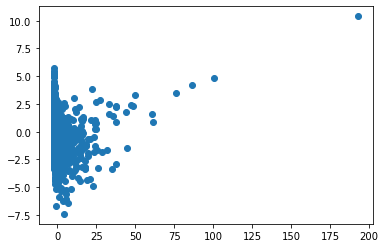

In [129]:
# plot pca
plt.scatter(econ_pca_pred['principal component 1'], econ_pca_pred['principal component 2'])
plt.show()

In [130]:
print(X_train.shape)
print(y_train.shape)
print(y_pred.shape)

(2286, 2)
(2286,)
(762,)


In [131]:
## model divided pred by 3

In [132]:
print(X_train)



[[-1.66304756  0.36337991]
 [-1.14642527 -0.62157069]
 [ 5.26022051  0.07267117]
 ...
 [-1.87115397  2.95371076]
 [-1.86861746  2.4892206 ]
 [-1.81658467 -0.55231179]]


In [133]:
print(y_train)

2075   -0.128502
1965    0.590982
2597    2.495008
506    -0.377778
822     0.183253
          ...   
2992    0.200000
2395    0.250886
1476   -0.178744
1361    0.130435
2611   -0.263768
Name: cases, Length: 2286, dtype: float64


In [134]:
print(y_pred)

[-3.34054750e-01  6.31488567e+00 -3.32534622e-01  9.58003221e-01
  8.25552335e-01  6.29049919e-02 -3.38009662e-01 -9.39774557e-02
  1.41694428e+01  2.84064412e-01 -3.94524960e-01 -2.74666667e-01
 -9.72495974e-02  1.51220612e-01  6.54299517e-02  2.00328502e-01
  3.08141707e-01  3.88856683e-02 -3.71259259e-01 -8.61191626e-02
  1.54750467e+01 -1.15748792e-02  1.74615974e+01 -3.33436393e-01
  3.40553945e-01 -2.86608696e-01  1.46859903e-03  1.49357810e+00
  4.62704026e+00 -3.23368760e-01 -1.94718196e-02 -7.56521739e-02
  4.87832528e-01 -3.63568438e-01  2.95022866e+00  1.42740097e+00
 -3.61674718e-01  2.49848631e-01  2.13087923e+00  2.19814493e+00
  2.39835749e+00 -2.54685990e-01 -8.47793881e-02  5.98376812e-01
  1.83561997e-01 -3.73294686e-01 -1.83446055e-02 -2.04128824e-01
  9.98718196e-01 -3.49977456e-01 -2.40579710e-01 -1.67085346e-01
  5.47594203e-01  1.06917874e-01  1.30892110e-01  2.51729469e-01
  1.82157810e-01 -2.11935588e-01  3.23377778e+00 -2.85101449e-01
  2.82962963e-02  2.63130

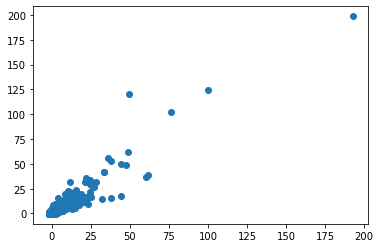

In [135]:
# plot training data
plt.scatter(X_train[:,0], y_train)

plt.show()

In [136]:
# check score
regressor.score(X_train, y_train)

0.9827657078266799

In [137]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('R Squared:', metrics.r2_score(y_test, y_pred))

Mean Absolute Error: 0.6043385953567396
Mean Squared Error: 1.9667771712390396
Root Mean Squared Error: 1.4024183296146124
R Squared: 0.93588466501601


In [138]:
pred_df = pd.DataFrame({'Real Values': y_test, 'Predicted Values': y_pred})
pred_df.head()

,Real Values,Predicted Values
1050,-0.367472,-0.334055
697,2.797746,6.314886
1636,-0.373913,-0.332535
2655,1.524960,0.958003
2752,0.047987,0.825552


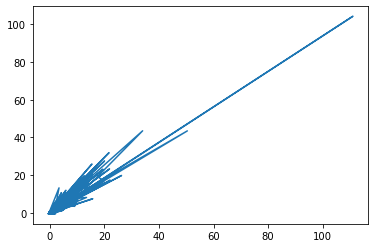

In [139]:
# plot line chart for predictions
plt.plot(pred_df['Predicted Values'], pred_df['Real Values'])
plt.show()

In [140]:
pred_df.shape

(762, 2)

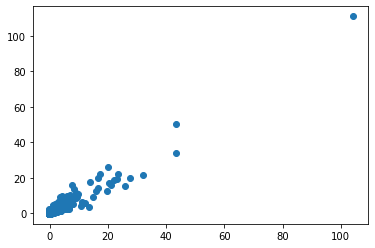

In [141]:
plt.scatter(pred_df['Real Values'], pred_df['Predicted Values'])
plt.show()

# RFR for Voting

In [142]:
# create voting df
voting_df = county_df[['cases','total_votes20','votes20_Donald_Trump','votes20_Joe_Biden']]
voting_df.head()

,cases,total_votes20,votes20_Donald_Trump,votes20_Joe_Biden
0,805.0,12433.0,8215.0,4101.0
1,3182.0,28425.0,22596.0,5443.0
2,1227.0,16938.0,9172.0,7578.0
3,17451.0,259389.0,130699.0,120539.0
4,222.0,4183.0,2917.0,1197.0


In [143]:
# scale voting data
voting_scaled = RobustScaler().fit_transform(voting_df)
voting_scaled[:5]

array([[ 0.09694042,  0.02301738,  0.01404871,  0.07280559],
       [ 1.62801932,  0.64584976,  0.90016483,  0.21554498],
       [ 0.36876006,  0.19847135,  0.07301631,  0.44263036],
       [10.81900161,  9.64108855,  7.56116272, 12.45752121],
       [-0.27858293, -0.29829122, -0.31239891, -0.23607307]])

In [144]:
# create scaled df
scaled_voting_df = pd.DataFrame(voting_scaled, columns= ['cases','total_votes20','votes20_Donald_Trump','votes20_Joe_Biden'])
scaled_voting_df.head()

,cases,total_votes20,votes20_Donald_Trump,votes20_Joe_Biden
0,0.096940,0.023017,0.014049,0.072806
1,1.628019,0.645850,0.900165,0.215545
2,0.368760,0.198471,0.073016,0.442630
3,10.819002,9.641089,7.561163,12.457521
4,-0.278583,-0.298291,-0.312399,-0.236073


In [145]:
# separate target
y2 = scaled_voting_df['cases']
scaled_cases2 = pd.DataFrame(y, columns = ['cases'])
scaled_cases2.head()

,cases
0,0.096940
1,1.628019
2,0.368760
3,10.819002
4,-0.278583


In [166]:
# create features for model
X_scaled2 = scaled_voting_df.drop(['cases'], axis=1)
X_scaled2.head()

,total_votes20,votes20_Donald_Trump,votes20_Joe_Biden
0,0.023017,0.014049,0.072806
1,0.645850,0.900165,0.215545
2,0.198471,0.073016,0.442630
3,9.641089,7.561163,12.457521
4,-0.298291,-0.312399,-0.236073


In [147]:
# get two principal components for the iris data
X2 = pca.fit_transform(X_scaled2)
X2[:5]

array([[-2.60478289, -0.27875697],
       [-1.96243507,  0.60491956],
       [-2.19494797, -0.33413577],
       [14.32089853,  3.76516877],
       [-3.10087786, -0.52185369]])

In [148]:
# instantiate model
regressor2 = RandomForestRegressor(n_estimators=100,random_state=48)

In [149]:
# split data into training and testing sets
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, random_state=48)

In [150]:
# fit model
regressor2.fit(X_train2, y_train2)

RandomForestRegressor(random_state=48)

In [151]:
# make predictions
y_pred2 = regressor2.predict(X_test2)
y_pred2[:5]

array([-0.3577649 ,  3.35680515, -0.39976812,  0.32586151,  0.13988406])

In [152]:
# plot components
print(pca.explained_variance_)

[135.08704538   2.61917516]


In [153]:
# Create df with pca and predictions
voting_pca_pred = pd.DataFrame(
    data=X2, columns=["principal component 1", "principal component 2"]
)
voting_pca_pred.head()

,principal component 1,principal component 2
0,-2.604783,-0.278757
1,-1.962435,0.604920
2,-2.194948,-0.334136
3,14.320899,3.765169
4,-3.100878,-0.521854


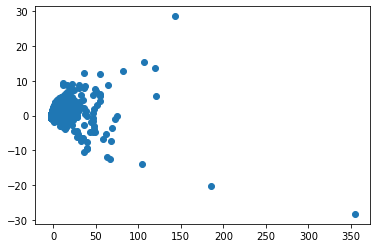

In [154]:
# plot pca
plt.scatter(voting_pca_pred['principal component 1'], voting_pca_pred['principal component 2'])
plt.show()

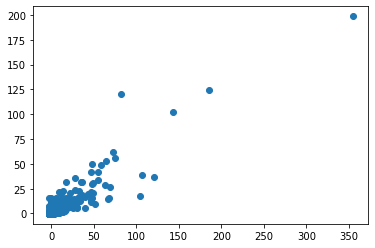

In [155]:
# plot training data
plt.scatter(X_train2[:,0], y_train2)
plt.show()

In [156]:
# check score
regressor.score(X_train2, y_train2)

0.11883870701235222

In [157]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('R Squared:', metrics.r2_score(y_test, y_pred))

Mean Absolute Error: 0.6043385953567396
Mean Squared Error: 1.9667771712390396
Root Mean Squared Error: 1.4024183296146124
R Squared: 0.93588466501601


In [158]:
# create df with predictions and actual values
voting_pred_df = pd.DataFrame({'Real Values': y_test2, 'Predicted Values': y_pred2})
voting_pred_df.head()

,Real Values,Predicted Values
1050,-0.367472,-0.357765
697,2.797746,3.356805
1636,-0.373913,-0.399768
2655,1.524960,0.325862
2752,0.047987,0.139884


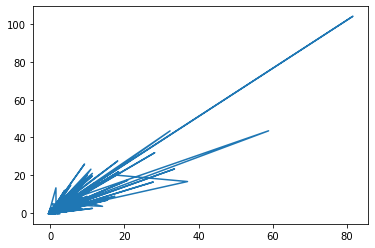

In [159]:
# plot line chart for predictions
plt.plot(voting_pred_df['Predicted Values'], voting_pred_df['Real Values'])
plt.show()

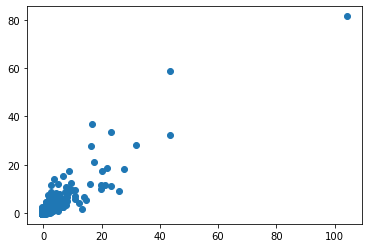

In [183]:
# plot predicted and real values
plt.scatter(voting_pred_df['Real Values'], voting_pred_df['Predicted Values'])
plt.show()

# RFR for Demographic Data

In [162]:
# create voting df
demo_df = county_df[['cases','Men', 'Women', 'Hispanic', 'White', 'Black', 'Native','Asian', 'Pacific']]
demo_df.head()

,cases,Men,Women,Hispanic,White,Black,Native,Asian,Pacific
0,805.0,12044.0,12744.0,1.3,68.9,27.6,0.1,0.3,0.0
1,3182.0,30433.0,32174.0,2.4,77.5,17.6,0.1,0.1,0.0
2,1227.0,16079.0,16761.0,8.8,60.3,28.3,0.3,0.7,0.0
3,17451.0,217999.0,217118.0,7.9,85.2,1.2,0.4,2.6,0.1
4,222.0,3552.0,3640.0,1.7,96.6,0.3,0.0,0.4,0.0


In [163]:
# scale demographic data
demo_scaled = RobustScaler().fit_transform(demo_df)
demo_scaled[:5]

array([[ 9.69404187e-02, -2.79136196e-02, -4.99800611e-03,
        -3.51351351e-01, -5.71428571e-01,  2.77173913e+00,
        -4.00000000e-01, -3.33333333e-01,  0.00000000e+00],
       [ 1.62801932e+00,  6.36987354e-01,  6.83734326e-01,
        -2.02702703e-01, -2.56410256e-01,  1.68478261e+00,
        -4.00000000e-01, -5.55555556e-01,  0.00000000e+00],
       [ 3.68760064e-01,  1.17982048e-01,  1.37391998e-01,
         6.62162162e-01, -8.86446886e-01,  2.84782609e+00,
         0.00000000e+00,  1.11111111e-01,  0.00000000e+00],
       [ 1.08190016e+01,  7.41891220e+00,  7.23941690e+00,
         5.40540541e-01,  2.56410256e-02, -9.78260870e-02,
         2.00000000e-01,  2.22222222e+00,  1.00000000e+00],
       [-2.78582931e-01, -3.34963436e-01, -3.27706146e-01,
        -2.97297297e-01,  4.43223443e-01, -1.95652174e-01,
        -6.00000000e-01, -2.22222222e-01,  0.00000000e+00]])

In [164]:
# create scaled df
scaled_demo_df = pd.DataFrame(demo_scaled, columns= ['cases','Men', 'Women', 'Hispanic', 'White', 'Black', 'Native','Asian', 'Pacific'])
scaled_demo_df.head()

,cases,Men,Women,Hispanic,White,Black,Native,Asian,Pacific
0,0.096940,-0.027914,-0.004998,-0.351351,-0.571429,2.771739,-0.4,-0.333333,0.0
1,1.628019,0.636987,0.683734,-0.202703,-0.256410,1.684783,-0.4,-0.555556,0.0
2,0.368760,0.117982,0.137392,0.662162,-0.886447,2.847826,0.0,0.111111,0.0
3,10.819002,7.418912,7.239417,0.540541,0.025641,-0.097826,0.2,2.222222,1.0
4,-0.278583,-0.334963,-0.327706,-0.297297,0.443223,-0.195652,-0.6,-0.222222,0.0


In [165]:
# separate target
y3 = scaled_demo_df['cases']
scaled_cases3 = pd.DataFrame(y, columns = ['cases'])
scaled_cases3.head()

,cases
0,0.096940
1,1.628019
2,0.368760
3,10.819002
4,-0.278583


In [167]:
# create features for model
X_scaled3 = scaled_demo_df.drop(['cases'], axis=1)
X_scaled3.head()

,Men,Women,Hispanic,White,Black,Native,Asian,Pacific
0,-0.027914,-0.004998,-0.351351,-0.571429,2.771739,-0.4,-0.333333,0.0
1,0.636987,0.683734,-0.202703,-0.256410,1.684783,-0.4,-0.555556,0.0
2,0.117982,0.137392,0.662162,-0.886447,2.847826,0.0,0.111111,0.0
3,7.418912,7.239417,0.540541,0.025641,-0.097826,0.2,2.222222,1.0
4,-0.334963,-0.327706,-0.297297,0.443223,-0.195652,-0.6,-0.222222,0.0


In [168]:
# get two principal components
X3 = pca.fit_transform(X_scaled3)
X3[:5]

array([[-2.8212884 , -2.31709428],
       [-2.85869588, -1.43335498],
       [-2.44160715, -1.96235347],
       [-2.76179951,  8.39265439],
       [-2.97885155, -2.8006906 ]])

In [169]:
# instantiate model
regressor3 = RandomForestRegressor(n_estimators=100,random_state=48)

In [170]:
# split data into training and testing sets
X_train3, X_test3, y_train3, y_test3 = train_test_split(X3, y3, random_state=48)

In [171]:
# fit model
regressor3.fit(X_train3, y_train3)

RandomForestRegressor(random_state=48)

In [172]:
# make predictions
y_pred3 = regressor3.predict(X_test3)
y_pred3[:5]

array([-0.39514332,  4.91777778, -0.11998712,  0.23055717,  0.39060225])

In [173]:
# explore pca
print(pca.explained_variance_)

[168.27437185  72.55441636]


In [175]:
# Create df with pca and predictions
demo_pca_pred = pd.DataFrame(
    data=X3, columns=["principal component 1", "principal component 2"]
)
demo_pca_pred.head()

,principal component 1,principal component 2
0,-2.821288,-2.317094
1,-2.858696,-1.433355
2,-2.441607,-1.962353
3,-2.761800,8.392654
4,-2.978852,-2.800691


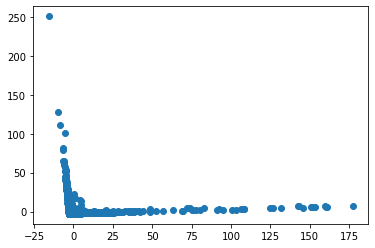

In [176]:
# plot pca
plt.scatter(demo_pca_pred['principal component 1'], demo_pca_pred['principal component 2'])
plt.show()

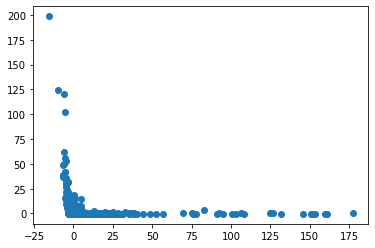

In [177]:
# plot training data
plt.scatter(X_train3[:,0], y_train3)
plt.show()

In [178]:
# check score
regressor.score(X_train3, y_train3)

-2.376273591149078

In [179]:
# print model assessment metrics
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('R Squared:', metrics.r2_score(y_test, y_pred))

Mean Absolute Error: 0.6043385953567396
Mean Squared Error: 1.9667771712390396
Root Mean Squared Error: 1.4024183296146124
R Squared: 0.93588466501601


In [181]:
# create df with predictions and actual values
demo_pred_df = pd.DataFrame({'Real Values': y_test2, 'Predicted Values': y_pred2})
demo_pred_df.head()

,Real Values,Predicted Values
1050,-0.367472,-0.357765
697,2.797746,3.356805
1636,-0.373913,-0.399768
2655,1.524960,0.325862
2752,0.047987,0.139884


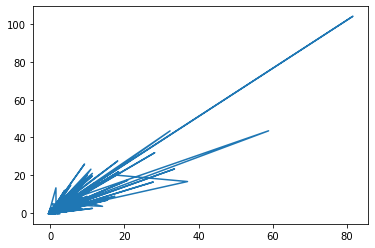

In [182]:
# plot line chart for predictions
plt.plot(demo_pred_df['Predicted Values'], demo_pred_df['Real Values'])
plt.show()

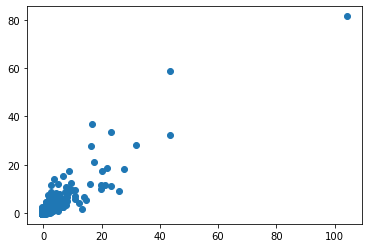

In [185]:
# plot scatter chart for predicted and real values
plt.scatter(voting_pred_df['Real Values'], voting_pred_df['Predicted Values'])
plt.show()